Shift Samples: 3


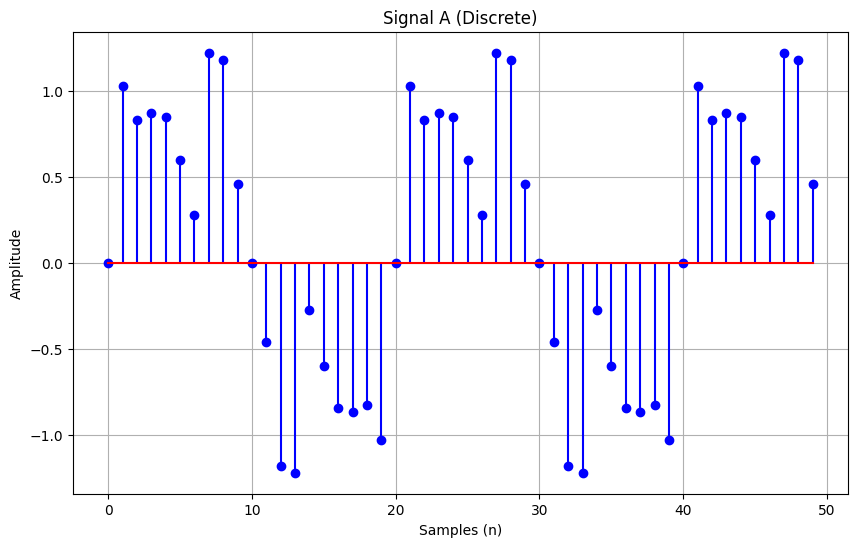

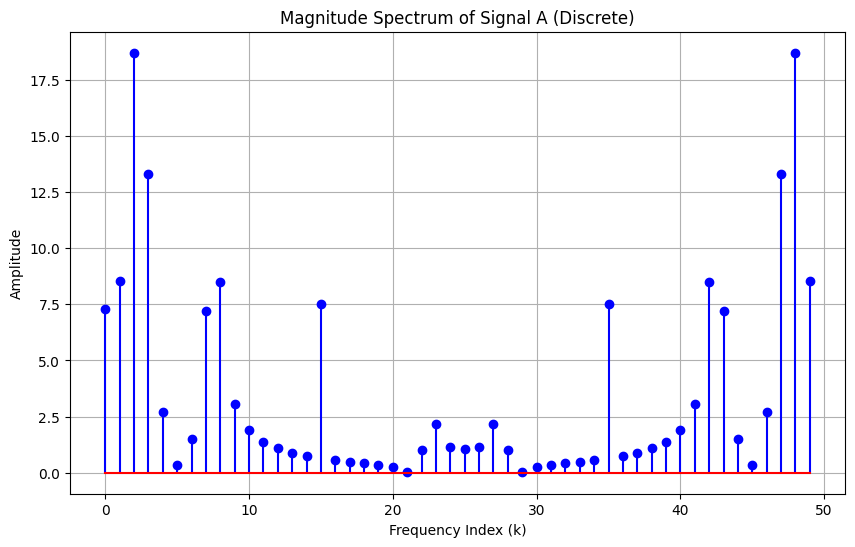

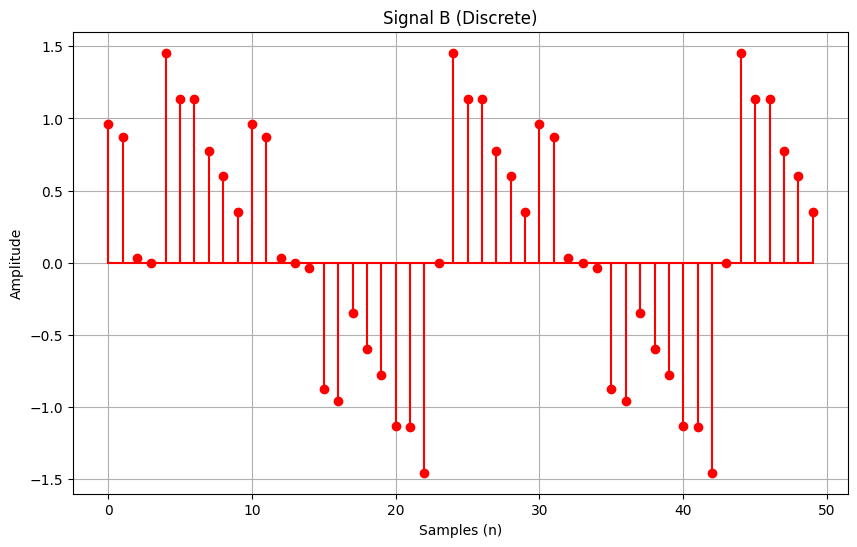

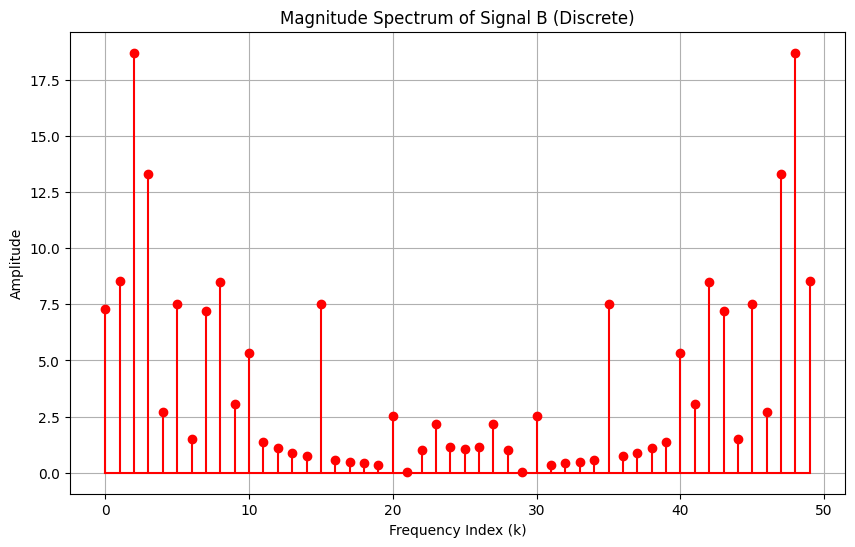

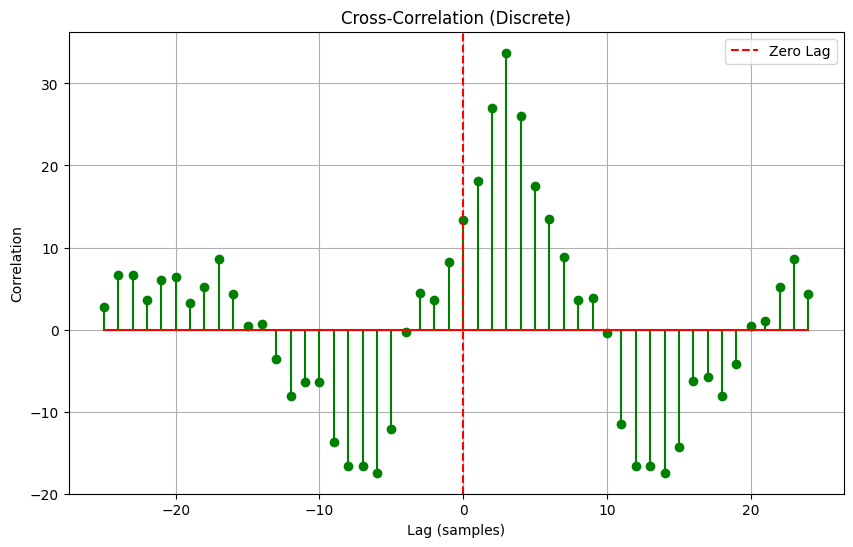

Sample lag is:   3
Distance:   240.0  meters


C:\Users\shams\AppData\Local\Temp\ipykernel_3308\1775915181.py:167: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


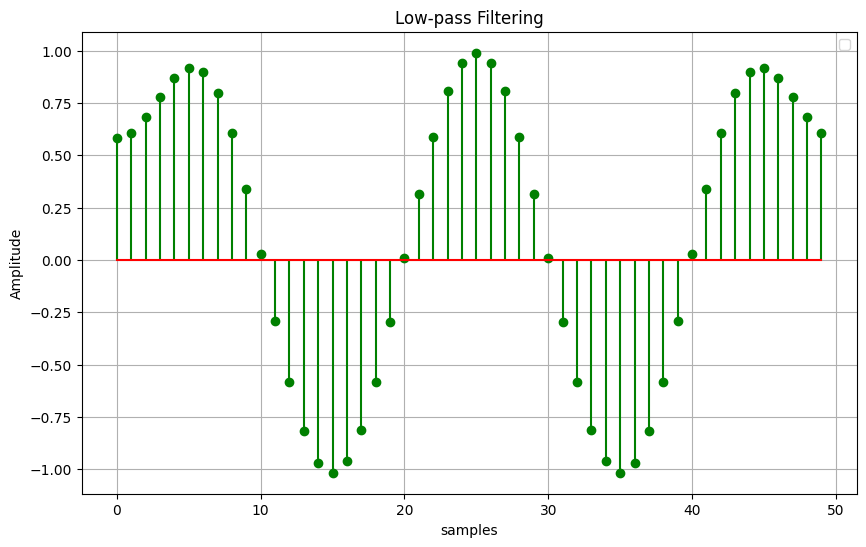

C:\Users\shams\AppData\Local\Temp\ipykernel_3308\1775915181.py:176: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


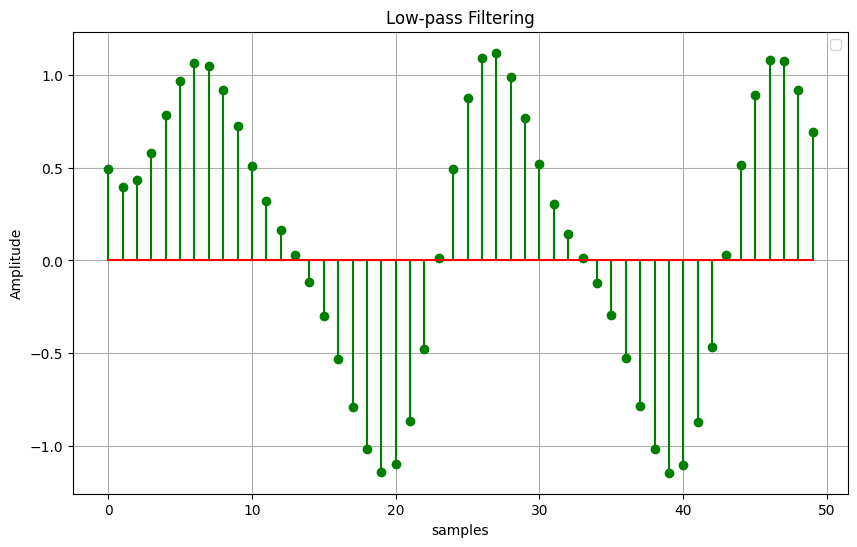

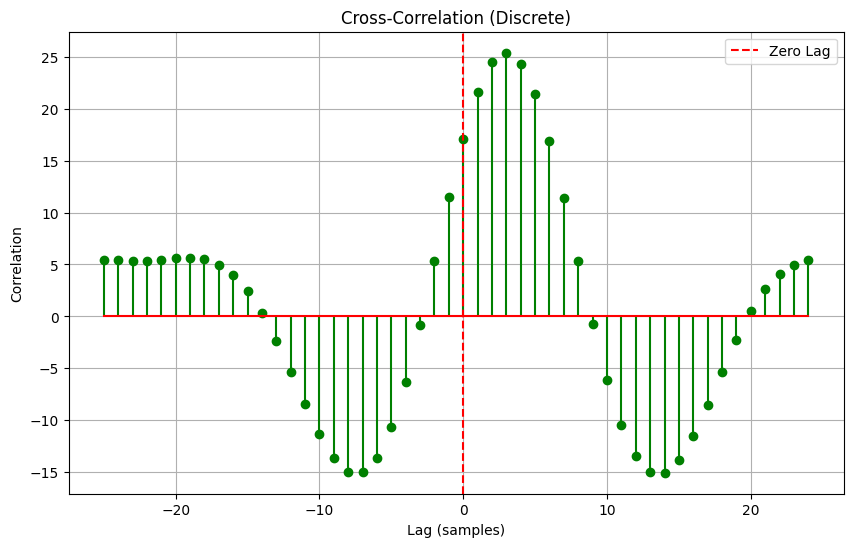

Sample lag is: (after filtering the noise)  3
Distance: (after filtering the noise)  240.0  meters


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

n=50
samples = np.arange(n) 
sampling_rate=100
wave_velocity=8000

#use this function to generate signal_A and signal_B with a random shift
def generate_signals(frequency=5):

    noise_freqs = [15, 30, 45]  # Default noise frequencies in Hz

    amplitudes = [0.5, 0.3, 0.1]  # Default noise amplitudes
    noise_freqs2 = [10, 20, 40] 
    amplitudes2 = [0.3, 0.2, 0.1]
    
     # Discrete sample indices
    dt = 1 / sampling_rate  # Sampling interval in seconds
    time = samples * dt  # Time points corresponding to each sample

    # Original clean signal (sinusoidal)
    original_signal = np.sin(2 * np.pi * frequency * time)

    # Adding noise
    noise_for_sigal_A = sum(amplitude * np.sin(2 * np.pi * noise_freq * time)
                for noise_freq, amplitude in zip(noise_freqs, amplitudes))
    noise_for_sigal_B = sum(amplitude * np.sin(2 * np.pi * noise_freq * time)
                for noise_freq, amplitude in zip(noise_freqs2, amplitudes2))
    signal_A = original_signal + noise_for_sigal_A 
    noisy_signal_B = signal_A + noise_for_sigal_B

    # Applying random shift
    shift_samples = np.random.randint(-n // 2, n // 2)  # Random shift
    shift_samples=3 #--------------------------------------------------------------------------------------- to match with the spec
    print(f"Shift Samples: {shift_samples}")
    signal_B = np.roll(noisy_signal_B, shift_samples)
    
    return signal_A, signal_B

#implement other functions and logic


def dft(signal):
    """Compute the Discrete Fourier Transform (DFT) of a signal."""
    N = len(signal)
    dft_output = np.zeros(N, dtype=complex)
    for k in range(N):
        for n in range(N):
            dft_output[k] += signal[n] * np.exp(-2j * np.pi * k * n / N)
    return dft_output

def idft(signal_freq):
    """Compute the Inverse Discrete Fourier Transform (IDFT)."""
    N = len(signal_freq)
    idft_output = np.zeros(N, dtype=complex)
    for n in range(N):
        for k in range(N):
            idft_output[n] += signal_freq[k] * np.exp(2j * np.pi * k * n / N)
    return idft_output / N

def cross_correlation(signal_A, signal_B):
    
    dft_A = dft(signal_A)
    dft_B = dft(signal_B)

    cross_corr_freq = dft_B * np.conj(dft_A)

    cross_corr_time = idft(cross_corr_freq)

    return np.real(cross_corr_time)



def find_sample_lag(cross_corr):
    return np.argmax(cross_corr) - len(cross_corr) // 2


def estimate_distance(sample_lag, sampling_rate, wave_velocity):
    time_delay = abs(sample_lag) / sampling_rate
    distance = time_delay * wave_velocity
    return distance

signal_A, signal_B = generate_signals()

dft_signal_A = dft(signal_A)
dft_signal_B = dft(signal_B)

magnitude_spectrum_A = np.abs(dft_signal_A)
magnitude_spectrum_B = np.abs(dft_signal_B)

def low_pass_filter(signal, threshold=7):
    N=len(signal)
    dft_signal=dft(signal)
    
    k=np.arange(N)
    f=k*sampling_rate/N
    f[k >= N//2]-=sampling_rate
    
    dft_flitered_signal=dft_signal.copy()
    dft_flitered_signal[np.abs(f)>threshold]=0
    
    denoised_signal=idft(dft_flitered_signal)
    return denoised_signal
    
plt.figure(figsize=(10, 6))
plt.stem(samples, signal_A, linefmt='b-', markerfmt='bo', basefmt='r-')
plt.title("Signal A (Discrete)")
plt.xlabel("Samples (n)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.stem(samples, magnitude_spectrum_A, linefmt='b-', markerfmt='bo', basefmt='r-')
plt.title("Magnitude Spectrum of Signal A (Discrete)")
plt.xlabel("Frequency Index (k)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.stem(samples, signal_B, linefmt='red', markerfmt='o', basefmt='r-')
plt.title("Signal B (Discrete)")
plt.xlabel("Samples (n)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.stem(samples, magnitude_spectrum_B, linefmt='red', markerfmt='o', basefmt='r-')
plt.title("Magnitude Spectrum of Signal B (Discrete)")
plt.xlabel("Frequency Index (k)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


cross_corr = cross_correlation(signal_A, signal_B)

lags = np.arange(-n // 2, n // 2)

cross_corr = np.roll(cross_corr, n // 2)

plt.figure(figsize=(10, 6))
plt.stem(lags, cross_corr, linefmt='g-', markerfmt='go', basefmt='r-')
plt.title("Cross-Correlation (Discrete)")
plt.xlabel("Lag (samples)")
plt.ylabel("Correlation")
plt.axvline(0, color='red', linestyle='--', label="Zero Lag")
plt.legend()
plt.grid(True)
plt.show()

print("Sample lag is:  ",find_sample_lag(cross_corr))
print("Distance:  ", estimate_distance(find_sample_lag(cross_corr), sampling_rate, wave_velocity), " meters")

flitered_signal_a=low_pass_filter(signal_A, 10)
flitered_signal_b=low_pass_filter(signal_B, 10)

plt.figure(figsize=(10, 6))
plt.stem(samples, flitered_signal_a, linefmt='g-', markerfmt='go', basefmt='r-')
plt.xlabel('samples')
plt.ylabel('Amplitude')
plt.title('Low-pass Filtering')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.stem(samples, flitered_signal_b, linefmt='g-', markerfmt='go', basefmt='r-')
plt.xlabel('samples')
plt.ylabel('Amplitude')
plt.title('Low-pass Filtering')
plt.legend()
plt.grid()
plt.show()

cross_corr = cross_correlation(flitered_signal_a, flitered_signal_b)

lags = np.arange(-n // 2, n // 2)

cross_corr = np.roll(cross_corr, n // 2)

plt.figure(figsize=(10, 6))
plt.stem(lags, cross_corr, linefmt='g-', markerfmt='go', basefmt='r-')
plt.title("Cross-Correlation (Discrete)")
plt.xlabel("Lag (samples)")
plt.ylabel("Correlation")
plt.axvline(0, color='red', linestyle='--', label="Zero Lag")
plt.legend()
plt.grid(True)
plt.show()

print("Sample lag is: (after filtering the noise) ",find_sample_lag(cross_corr))
print("Distance: (after filtering the noise) ", estimate_distance(find_sample_lag(cross_corr), sampling_rate, wave_velocity), " meters")


